It's called transfer learning, in other words, taking the patterns (also called weights) another model has learned from another problem and using them for our own problem.

There are two main benefits to using transfer learning:

Can leverage an existing neural network architecture proven to work on problems similar to our own.
Can leverage a working neural network architecture which has already learned patterns on similar data to our own. This often results in achieving great results with less custom data.
What this means is, instead of hand-crafting our own neural network architectures or building them from scratch, we can utilise models which have worked for others.

And instead of training our own models from scratch on our own datasets, we can take the patterns a model has learned from datasets such as ImageNet (millions of images of different objects) and use them as the foundation of our own. Doing this often leads to getting great results with less data.

Over the next few notebooks, we'll see the power of transfer learning in action.

In [4]:
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()


--2022-06-28 20:27:49--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 108.177.98.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   231MB/s    in 0.7s    

2022-06-28 20:27:50 (231 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [5]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ch

In [6]:
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32


train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"



train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)


### THIS SPLIT THE DATA IMAGES IN BATCHES FOR FASTER LEARNING
print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")


Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)
Before we build a model, there's an important concept we're going to get familiar with because it's going to play a key role in our future model building experiments.

And that concept is callbacks.

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks include:

##Experiment tracking with TensorBoard 
- log the performance of multiple models and then view and compare these models in a visual way on TensorBoard (a dashboard for inspecting neural network parameters). Helpful to compare the results of different models on your data.


##Model checkpointing 
- save your model as it trains so you can stop training if needed and come back to continue off where you left. Helpful if training takes a long time and can't be done in one sitting.


##Early stopping 
- leave your model training for an arbitrary amount of time and have it stop training automatically when it ceases to improve. Helpful when you've got a large dataset and don't know how long training will take.

We'll explore each of these overtime but for this notebook, we'll see how the TensorBoard callback can be used.

The TensorBoard callback can be accessed using tf.keras.callbacks.TensorBoard().

Its main functionality is saving a model's training performance metrics to a specified log_dir.

By default, logs are recorded every epoch using the update_freq='epoch' parameter. This is a good default since tracking model performance too often can slow down model training.

To track our modelling experiments using TensorBoard, let's create a function which creates a TensorBoard callback for us.

In [7]:
## TensorBoard Callbacks ( functionize because we need to screate a new one for each model)

import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

  

##Tensorflow Hub: Allow us to use models that are pretrain models.

Following the next model https://tfhub.dev/google/efficientnet/b0/feature-vector/1 for image clasification.

https://paperswithcode.com/sota -> give us the best architecture for each problem


## Lets compare the following two models

resnet_v2_50: https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5

EfficientNet: https://tfhub.dev/google/efficientnet/b0/feature-vector/1

In [8]:
import tensorflow as tf 
import tensorflow_hub as hub
from tensorflow.keras import layers

def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model



In [9]:
Model_Resnet = create_model("https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5", num_classes= train_data_10_percent.num_classes)
Model_Resnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1001)             25615849  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                10020     
                                                                 
Total params: 25,625,869
Trainable params: 10,020
Non-trainable params: 25,615,849
_________________________________________________________________


In [10]:
## Compile Model
Model_Resnet.compile(loss = "categorical_crossentropy",
                     optimizer= tf.keras.optimizers.Adam(),
                     metrics = "accuracy")

# Fit the model

history_resnet =Model_Resnet.fit(train_data_10_percent,
                 epochs = 5,
                 steps_per_epoch=len(train_data_10_percent),
                 validation_data=test_data,
                 validation_steps=len(test_data),
                 callbacks= [create_tensorboard_callback(dir_name=" tensorflow_hub",
                                                         experiment_name ="resnet50v2")] )



Saving TensorBoard log files to:  tensorflow_hub/resnet50v2/20220628-202804
Epoch 1/5
24/24 [==============================] - 36s 900ms/step - loss: 2.3639 - accuracy: 0.3347 - val_loss: 1.2932 - val_accuracy: 0.5784
Epoch 2/5
24/24 [==============================] - 17s 718ms/step - loss: 1.0032 - accuracy: 0.6680 - val_loss: 0.9297 - val_accuracy: 0.6980
Epoch 3/5
24/24 [==============================] - 17s 730ms/step - loss: 0.7088 - accuracy: 0.7707 - val_loss: 0.8691 - val_accuracy: 0.7160
Epoch 4/5
24/24 [==============================] - 15s 664ms/step - loss: 0.5457 - accuracy: 0.8453 - val_loss: 0.8027 - val_accuracy: 0.7296
Epoch 5/5
24/24 [==============================] - 16s 666ms/step - loss: 0.4480 - accuracy: 0.8693 - val_loss: 0.7914 - val_accuracy: 0.7480


In [11]:
Model_Resnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1001)             25615849  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                10020     
                                                                 
Total params: 25,625,869
Trainable params: 10,020
Non-trainable params: 25,615,849
_________________________________________________________________


In [12]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

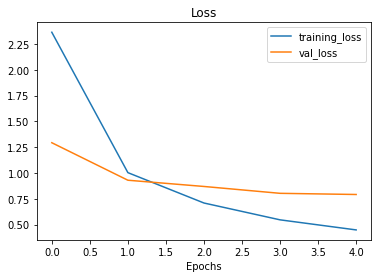

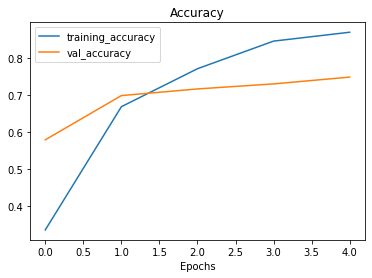

In [13]:
plot_loss_curves(history_resnet)


## Model EfficientNet


In [14]:
Model_EfficientNet = create_model("https://tfhub.dev/google/efficientnet/b0/feature-vector/1", num_classes= train_data_10_percent.num_classes)
Model_EfficientNet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [15]:
## Compile Model
Model_EfficientNet.compile(loss = "categorical_crossentropy",
                     optimizer= tf.keras.optimizers.Adam(),
                     metrics = "accuracy")

# Fit the model

history_Efficientnet =Model_EfficientNet.fit(train_data_10_percent,
                 epochs = 5,
                 steps_per_epoch=len(train_data_10_percent),
                 validation_data=test_data,
                 validation_steps=len(test_data),
                 callbacks= [create_tensorboard_callback(dir_name=" tensorflow_hub",
                                                         experiment_name ="EfficientNet")] )


Saving TensorBoard log files to:  tensorflow_hub/EfficientNet/20220628-202949
Epoch 1/5
24/24 [==============================] - 20s 699ms/step - loss: 1.8894 - accuracy: 0.4147 - val_loss: 1.3328 - val_accuracy: 0.7380
Epoch 2/5
24/24 [==============================] - 15s 656ms/step - loss: 1.0900 - accuracy: 0.7813 - val_loss: 0.8836 - val_accuracy: 0.8232
Epoch 3/5
24/24 [==============================] - 15s 664ms/step - loss: 0.7762 - accuracy: 0.8333 - val_loss: 0.7045 - val_accuracy: 0.8440
Epoch 4/5
24/24 [==============================] - 15s 636ms/step - loss: 0.6204 - accuracy: 0.8667 - val_loss: 0.6142 - val_accuracy: 0.8532
Epoch 5/5
24/24 [==============================] - 15s 635ms/step - loss: 0.5232 - accuracy: 0.8907 - val_loss: 0.5579 - val_accuracy: 0.8652


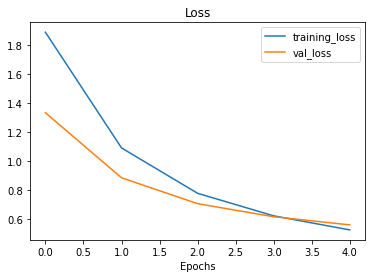

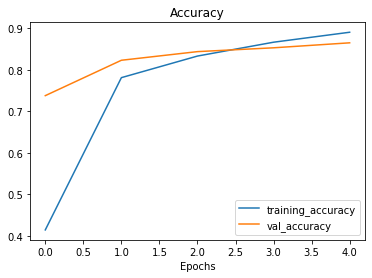

In [16]:
plot_loss_curves(history_Efficientnet)


## Types of Transfer Learning 

##"As is" transfer learning 

is when you take a pretrained model as it is and apply it to your task without any changes.

For example, many computer vision models are pretrained on the ImageNet dataset which contains 1000 different classes of images. This means passing a single image to this model will produce 1000 different prediction probability values (1 for each class).

This is helpful if you have 1000 classes of image you'd like to classify and they're all the same as the ImageNet classes, however, it's not helpful if you want to classify only a small subset of classes (such as 10 different kinds of food). Model's with "/classification" in their name on TensorFlow Hub provide this kind of functionality.

##Feature extraction transfer learning
is when you take the underlying patterns (also called weights) a pretrained model has learned and adjust its outputs to be more suited to your problem.

For example, say the pretrained model you were using had 236 different layers (EfficientNetB0 has 236 layers), but the top layer outputs 1000 classes because it was pretrained on ImageNet. To adjust this to your own problem, you might remove the original activation layer and replace it with your own but with the right number of output classes. The important part here is that only the top few layers become trainable, the rest remain frozen.

This way all the underlying patterns remain in the rest of the layers and you can utilise them for your own problem. This kind of transfer learning is very helpful when your data is similar to the data a model has been pretrained on.


##Fine-tuning transfer learning 

is when you take the underlying patterns (also called weights) of a pretrained model and adjust (fine-tune) them to your own problem.

This usually means training some, many or all of the layers in the pretrained model. This is useful when you've got a large dataset (e.g. 100+ images per class) where your data is slightly different to the data the original model was trained on.
A common workflow is to "freeze" all of the learned patterns in the bottom layers of a pretrained model so they're untrainable. And then train the top 2-3 layers of so the pretrained model can adjust its outputs to your custom data (feature extraction).

## Comparing our models result using TensorBoard


In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) 